# Active Learning Experiments

## Strategy Comparison

In [1]:
!rsync -avz cluster.ies:/mnt/home/dhuseljic/mlflow/pseudo_batch /home/dhuseljic/mlflow 

receiving incremental file list
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/4529b42b605c4a87a3a7220ce364e751/
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/4529b42b605c4a87a3a7220ce364e751/meta.yaml
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/4529b42b605c4a87a3a7220ce364e751/artifacts/
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/4529b42b605c4a87a3a7220ce364e751/metrics/
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/4529b42b605c4a87a3a7220ce364e751/metrics/base_ACE
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/4529b42b605c4a87a3a7220ce364e751/metrics/base_ECE
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/4529b42b605c4a87a3a7220ce364e751/metrics/base_accuracy
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/4529b42b605c4a87a3a7220ce364e751/metrics/fo_updated_ACE
pseudo_batch/dbpedia_gamma_ablation_mc/765857091053921413/4529b42b605c4

In [1]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

plt.style.use('bmh')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
dataset = 'cifar10'
client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_al_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri=f'file:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_al_ablation/')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [3]:
strat = 'badge'

runs = []
init_query_list = [
    # "parameter.al.num_acq = '20'",
    # "parameter.al.acq_size = '100'",
    # "parameter.al.num_init_samples = '10'",
    # "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.al.init_method = 'random'",
    "parameter.use_val_split = 'False'"
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# Adding strat with single instance acq
query_list = init_query_list + [f"parameter.al.strategy = '{strat}'"]
query_list.append("parameter.al.acq_size != '1'")
query_list.append("parameter.model.mean_field_factor != '10'")
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + [f"parameter.al.strategy = '{strat}'"] 
query_list.append("parameter.al.acq_size = '1'")
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'single_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + [f"parameter.al.strategy = 'pseudo_{strat}'"]
query_list.append("parameter.update_gamma = '15'")
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

runs = [run for run in runs if int(run.data.params['random_seed']) <= 20]

print('Found {} experiments'.format(len(runs)))

Found 60 experiments


In [4]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    lc = [metric.value for metric in acc_history]
    if len(lc) != int(run.data.params['al.num_acq'])+1:
        print(run.data.params['random_seed'], al_strat)
        continue

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])

    learning_curves[al_strat].append(lc)
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))

[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21] badge
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21] pseudo_badge
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21] random


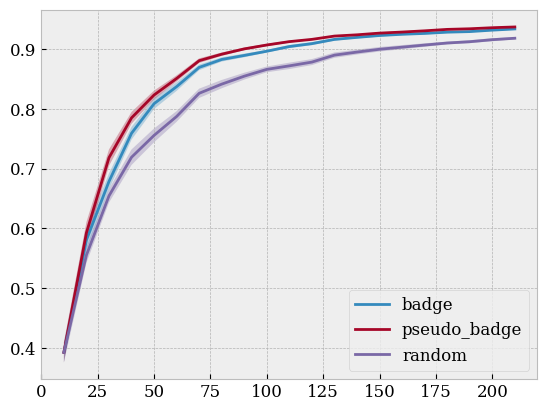

In [5]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]

    max_seeds = np.max([len(lc) for lc in lcs])
    lcs = [lc for lc in lcs if len(lc) == max_seeds]

    print([len(lc) for lc in lcs], al_strat)
    lc = np.mean(lcs, axis=0)
    stderr = np.std(lcs, axis=0) / np.sqrt(10)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    plt.fill_between(axis, lc - stderr, lc + stderr, alpha=.3)

plt.legend()
plt.show()

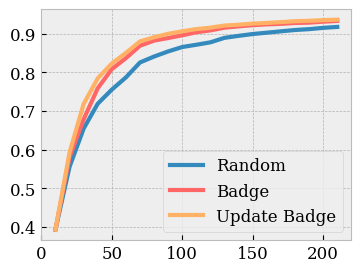

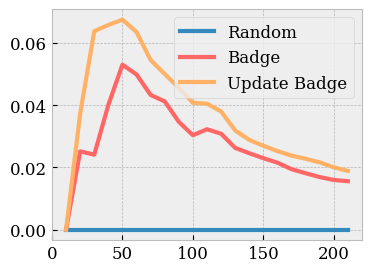

In [6]:
colors = ["#FF6666", "#FFB266", "#66FF66", "#66B2FF", "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]
plt.figure(figsize=(4, 3))

# stderr = np.std(lcs, axis=0) / np.sqrt(10)
axis = np.mean(num_samples['random'], axis=0)
plt.plot(axis, np.mean(learning_curves['random'], axis=0), label='Random', linewidth=3)
plt.plot(axis, np.mean(learning_curves[f'{strat}'], axis=0), label=strat.capitalize(), linewidth=3, color=colors[0])
plt.plot(axis, np.mean(learning_curves[f'pseudo_{strat}'], axis=0), label=f'Update {strat.capitalize()}', linewidth=3, color=colors[1])

plt.legend()
plt.savefig(f'al_lc_{dataset}_{strat}.pdf')
plt.show()

plt.figure(figsize=(4, 3))

# stderr = np.std(lcs, axis=0) / np.sqrt(10)
axis = np.mean(num_samples['random'], axis=0)
lc_random = np.mean(learning_curves['random'], axis=0)
plt.plot(axis, np.mean(learning_curves['random'], axis=0) - lc_random, label='Random', linewidth=3)
plt.plot(axis, np.mean(learning_curves[f'{strat}'], axis=0) - lc_random, label=strat.capitalize(), linewidth=3, color=colors[0])
plt.plot(axis, np.mean(learning_curves[f'pseudo_{strat}'] - lc_random, axis=0), label=f'Update {strat.capitalize()}', linewidth=3, color=colors[1])

plt.legend()
plt.savefig(f'al_lcdiff_{dataset}_{strat}.pdf')
plt.show()